<a href="https://colab.research.google.com/github/Zach227/ComputingBootCamp/blob/main/proj3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
%%bash
mv ../data2.zip ./
unzip data2.zip

## Create Datasets

In [17]:
import numpy as np
import random

def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    print(f"Random seed set as {seed}")

In [51]:
from custom_dataset import CustomImageDataset
from torch.utils.data import DataLoader
set_seed(11)

transform = transforms.Compose(
    [
        transforms.Resize((120, 120)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
batch_size = 2

data = CustomImageDataset(
    "data/train/train.csv", "data/train/", transform=transform
)

train_val_size = int(0.9 * len(data))
test_size = len(data) - train_val_size
train_size = int(0.9 * train_val_size)
val_size = train_val_size - train_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    data, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ["None", "glioma", "meningioma", "pituitary"]

Random seed set as 11


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


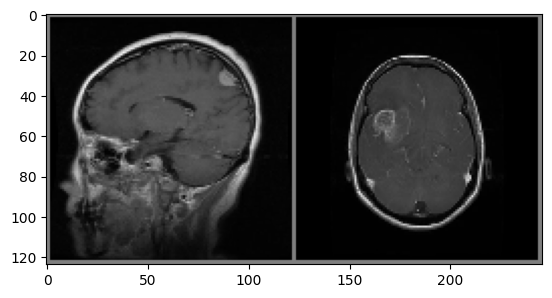

meningioma glioma
torch.Size([2, 3, 120, 120])


In [52]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# image, label = trainset.__getitem__(220)
# print(image.shape)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# # show images
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))
print(images.shape)

## Dummy Classifier

In [53]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="uniform")
train_labels = []

for images, labels in train_loader:
  for label in labels:
    train_labels.append(label)

dummy_classifier.fit(train_dataset, train_labels)


# test the dummy classifier on the test set
correct = 0
total = 0
for images, labels in test_loader:
    outputs = dummy_classifier.predict(images)
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            correct += 1
        total += 1

print("Accuracy of the network on the test images: %d %%" % (100 * correct / total))


Accuracy of the network on the test images: 25 %


## Define Networks

In [54]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 15 * 15, 64)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 15 * 15)  # Adjust the size based on your image dimensions

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [55]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Additional convolutional layer
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(128, 64)  # Extra fully connected layer
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))  # Additional layer

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)  # Adjust the size based on your image dimensions

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # Extra fully connected layer
        x = self.fc3(x)

        return x


In [61]:
import torch.nn as nn
import torch.nn.functional as F


class WiderCNN(nn.Module):
    def __init__(self):
        super(WiderCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 15 * 15, 128)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 15 * 15)  # Adjust the size based on your image dimensions

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Hyperparameter Sweep

In [56]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    print(f"Random seed set as {seed}")


In [62]:
import torch.optim as optim


results_dict = {}
for criterion in [nn.CrossEntropyLoss()]:
  for learning_rate in [0.005, 0.001]:
    for opt in ['Adam', 'RMSprop', 'SGD']:

      set_seed(31)
      model = WiderCNN()
      if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
      elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


      device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
      model.to(device)

      val_stats = []
      for epoch in range(20):  # loop over the dataset multiple times
          for i, data in enumerate(train_loader, 0):
              # get the inputs; data is a list of [inputs, labels]
              inputs, labels = data[0].to(device), data[1].to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward + backward + optimize
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()

          # Validation
          correct = 0
          total = 0
          with torch.no_grad():
              for data in val_loader:
                  inputs, labels = data[0].to(device), data[1].to(device)
                  outputs = model(inputs)
                  _, predicted = torch.max(outputs.data, 1)  # returns max value, indices
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
          accuracy = correct / total
          hyp_params = f'batch_size={batch_size}, criterion={criterion}, learning rate={learning_rate}, optimizer = {opt}, epochs = {epoch+1}'
          results_dict[hyp_params] = accuracy
          print(f'{hyp_params} ---> {1-accuracy}')

Random seed set as 31
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 1 ---> 0.7142857142857143
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 2 ---> 0.7074829931972789
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 3 ---> 0.7551020408163265
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 4 ---> 0.7142857142857143
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 5 ---> 0.7551020408163265
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 6 ---> 0.7551020408163265
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 7 ---> 0.7551020408163265
batch_size=2, criterion=CrossEntropyLoss(), learning rate=0.005, optimizer = Adam, epochs = 8 ---> 0.7551020408163265
batch_size=2, criterion=CrossEntro

In [ ]:
PATH = "./proj3_model.pth"
torch.save(model.state_dict(), PATH)

/Users/zacharydriskill/Desktop/ECEN493/envML/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


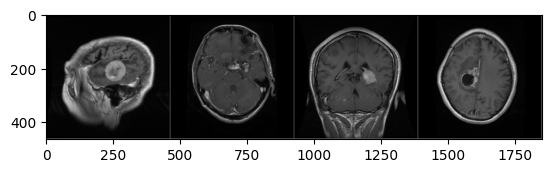

GroundTruth:  meningioma glioma meningioma glioma
Predicted:  meningioma glioma pituitary meningioma


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))


net = CNN()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images: {100 * correct // total} %")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on the test images: 69 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy for class: None  is 91.4 %
Accuracy for class: glioma is 21.0 %
Accuracy for class: meningioma is 87.8 %
Accuracy for class: pituitary is 73.0 %
